# 데이터 다운로드

In [ ]:
# 용량 문제로 케글에서는 압축해제 불가
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1JxLLEBlwt8qtEOpxMSHAKRYapU7ycDaJ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1JxLLEBlwt8qtEOpxMSHAKRYapU7ycDaJ" -O open.zip && rm -rf ~/cookies.txt
!mkdir data
!unzip open.zip -d data
!rm open.zip

# load

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit

import warnings
warnings.filterwarnings(action='ignore') 

In [3]:
base = '/Users/krc/Downloads/tabluer_imgfeature_ratio/'

In [4]:
train_df = pd.read_csv(base + 'train+imgf.csv') # gleason score weights 5
test_df = pd.read_csv(base + 'test+imgf.csv') 
# train_df = pd.read_csv(base + 'train+imgf2.csv') # just feature extract 10
# test_df = pd.read_csv(base + 'test+imgf2.csv')

train_ratio = pd.read_csv(base + 'train_ratio2.csv') # ratio from whole image
test_ratio = pd.read_csv(base + 'test_ratio2.csv')

#train_ratio = pd.read_csv(base + 'train_ratio.csv') # ratio from cropped image
#test_ratio = pd.read_csv(base + 'test_ratio.csv')
#train_df = pd.read_csv(base + 'train.csv')
#test_df = pd.read_csv(base + 'test.csv')

In [5]:
train_ratio['path'] = train_ratio['path'].str.replace('.png', '')
train_ratio.columns = ['ID', 'ratio']
train_df = pd.merge(train_df, train_ratio)

test_ratio['path'] = test_ratio['path'].str.replace('.png', '')
test_ratio.columns = ['ID', 'ratio']
test_df = pd.merge(test_df, test_ratio)

In [6]:
train_df.head()

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category,img_feature1,img_feature2,img_feature3,img_feature4,img_feature5,ratio
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,NaN,NaN,NaN,0,0.004472,0.000065,0.000948,0.000169,0.043030,0.223823
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,NaN,NaN,1,0.004062,0.000334,0.002791,0.001100,0.046014,0.103199
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,NaN,NaN,0.0,0,0.048549,0.000922,0.004332,0.000008,0.000284,0.110550
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,NaN,NaN,NaN,0,0.081638,0.000208,0.001114,0.000039,0.000219,0.465184
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,1.0,5.44,NaN,0,0.048623,0.014016,0.077193,0.000926,0.007830,0.154556


# 전처리

In [7]:
# 한글 컬럼명 영문으로 변경
train_df = train_df.rename(columns={'나이':'age','수술연월일':'date', '진단명':'Diagnosis', '암의 위치':'location', '암의 개수':'count', '암의 장경':'size', 'DCIS_or_LCIS_여부':'DCIS_or_LCIS_existence'}) 
test_df = test_df.rename(columns={'나이':'age','수술연월일':'date', '진단명':'Diagnosis', '암의 위치':'location', '암의 개수':'count', '암의 장경':'size', 'DCIS_or_LCIS_여부':'DCIS_or_LCIS_existence'}) 

## feature 변환

In [8]:
# date 변환

import datetime as dt
someday = pd.to_datetime('2000-01-01')
train_df['date'] = pd.to_datetime(train_df['date']) - someday
train_df['date'] = train_df['date'].dt.days / 1000

test_df['date'] = pd.to_datetime(test_df['date']) - someday
test_df['date'] = test_df['date'].dt.days / 1000

In [9]:
# 0이 의미가 있는 컬럼들은 숫자를 1씩 올려줘서 nan값이 채워지는 0과 구분할수 있게 해줌.

train_df['DCIS_or_LCIS_existence'] += 1
train_df['ER'] += 1
train_df['HER2'] += 1
train_df['HER2_IHC'] += 1

test_df['DCIS_or_LCIS_existence'] += 1
test_df['ER'] += 1
test_df['HER2'] += 1
test_df['HER2_IHC'] += 1

## 이상치 제거

In [10]:
# 휴먼에러 제거
train_df['PR_Allred_score'].loc[train_df['PR_Allred_score']==23] = 3
train_df['PR_Allred_score'].loc[train_df['PR_Allred_score']==54] = 4

## 결측치 채우기

## 컬럼삭제

## One hot encoding

In [11]:
train_df['location_left'] = train_df['location'].apply(lambda x :1 if x==1 else 0)
train_df['location_right'] = train_df['location'].apply(lambda x :1 if x==2 else 0)
train_df['location_both'] = train_df['location'].apply(lambda x :1 if x==3 else 0)

train_df['Diagnosis_ductal'] = train_df['Diagnosis'].apply(lambda x :1 if x==1 else 0)
train_df['Diagnosis_lobular'] = train_df['Diagnosis'].apply(lambda x :1 if x==2 else 0)
train_df['Diagnosis_mucinous'] = train_df['Diagnosis'].apply(lambda x :1 if x==3 else 0)
train_df['Diagnosis_other'] = train_df['Diagnosis'].apply(lambda x :1 if x==4 else 0)

test_df['location_left'] = test_df['location'].apply(lambda x :1 if x==1 else 0)
test_df['location_right'] = test_df['location'].apply(lambda x :1 if x==2 else 0)
test_df['location_both'] = test_df['location'].apply(lambda x :1 if x==3 else 0)

test_df['Diagnosis_ductal'] = test_df['Diagnosis'].apply(lambda x :1 if x==1 else 0)
test_df['Diagnosis_lobular'] = test_df['Diagnosis'].apply(lambda x :1 if x==2 else 0)
test_df['Diagnosis_mucinous'] = test_df['Diagnosis'].apply(lambda x :1 if x==3 else 0)
test_df['Diagnosis_other'] = test_df['Diagnosis'].apply(lambda x :1 if x==4 else 0)

train_df = train_df.drop(columns = ['location','Diagnosis',])
test_df = test_df.drop(columns = ['location','Diagnosis',])

In [15]:

train_df['KI-67_LI_percent'].loc[(train_df['KI-67_LI_percent'].isnull() == True) & (train_df['T_category']==1)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==1].median()
train_df['KI-67_LI_percent'].loc[(train_df['KI-67_LI_percent'].isnull() == True) & (train_df['T_category']==2)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==2].median()
train_df['KI-67_LI_percent'].loc[(train_df['KI-67_LI_percent'].isnull() == True) & (train_df['T_category']==3)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==3].median()
train_df['KI-67_LI_percent'].loc[(train_df['KI-67_LI_percent'].isnull() == True) & (train_df['T_category']==4)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==4].median()


test_df['KI-67_LI_percent'].loc[(test_df['KI-67_LI_percent'].isnull() == True) & (test_df['T_category']==1)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==1].median()
test_df['KI-67_LI_percent'].loc[(test_df['KI-67_LI_percent'].isnull() == True) & (test_df['T_category']==2)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==2].median()
test_df['KI-67_LI_percent'].loc[(test_df['KI-67_LI_percent'].isnull() == True) & (test_df['T_category']==3)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==3].median()
test_df['KI-67_LI_percent'].loc[(test_df['KI-67_LI_percent'].isnull() == True) & (test_df['T_category']==4)] = train_df['KI-67_LI_percent'].loc[train_df['T_category']==4].median()


train_df['size'].loc[(train_df['size'].isnull() == True) & (train_df['T_category']==1)] = train_df['size'].loc[train_df['T_category']==1].median()
train_df['size'].loc[(train_df['size'].isnull() == True) & (train_df['T_category']==2)] = train_df['size'].loc[train_df['T_category']==2].median()
train_df['size'].loc[(train_df['size'].isnull() == True) & (train_df['T_category']==3)] = train_df['size'].loc[train_df['T_category']==3].median()
train_df['size'].loc[(train_df['size'].isnull() == True) & (train_df['T_category']==4)] = train_df['size'].loc[train_df['T_category']==4].median()


test_df['size'].loc[(test_df['size'].isnull() == True) & (test_df['T_category']==1)] = train_df['size'].loc[train_df['T_category']==1].median()
test_df['size'].loc[(test_df['size'].isnull() == True) & (test_df['T_category']==2)] = train_df['size'].loc[train_df['T_category']==2].median()
test_df['size'].loc[(test_df['size'].isnull() == True) & (test_df['T_category']==3)] = train_df['size'].loc[train_df['T_category']==3].median()
test_df['size'].loc[(test_df['size'].isnull() == True) & (test_df['T_category']==4)] = train_df['size'].loc[train_df['T_category']==4].median()


train_df['PR_Allred_score'].loc[(train_df['PR_Allred_score'].isnull() == True) & (train_df['NG']==1)] = int(train_df['PR_Allred_score'].loc[train_df['NG']==1].mean())
train_df['PR_Allred_score'].loc[(train_df['PR_Allred_score'].isnull() == True) & (train_df['NG']==2)] = int(train_df['PR_Allred_score'].loc[train_df['NG']==2].mean())
train_df['PR_Allred_score'].loc[(train_df['PR_Allred_score'].isnull() == True) & (train_df['NG']==3)] = int(train_df['PR_Allred_score'].loc[train_df['NG']==3].mean())

test_df['PR_Allred_score'].loc[(test_df['PR_Allred_score'].isnull() == True) & (test_df['NG']==1)] = int(train_df['PR_Allred_score'].loc[train_df['NG']==1].mean())
test_df['PR_Allred_score'].loc[(test_df['PR_Allred_score'].isnull() == True) & (test_df['NG']==2)] = int(train_df['PR_Allred_score'].loc[train_df['NG']==2].mean())
test_df['PR_Allred_score'].loc[(test_df['PR_Allred_score'].isnull() == True) & (test_df['NG']==3)] = int(train_df['PR_Allred_score'].loc[train_df['NG']==3].mean())



In [16]:

train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [17]:
# 필수삭제 columns

train_df = train_df.drop(columns = ['ID','img_path','mask_path'])
test_df = test_df.drop(columns = ['ID','img_path'])

In [18]:
train_df = train_df.drop(columns = ['HG_score_2','HER2_SISH','HER2_SISH_ratio','BRCA_mutation',])
test_df = test_df.drop(columns = ['HG_score_2','HER2_SISH','HER2_SISH_ratio','BRCA_mutation',])

# wandb setting

In [ ]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 7.4 MB/s 
     |████████████████████████████████| 182 kB 68.8 MB/s 
     |████████████████████████████████| 168 kB 56.2 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 168 kB 66.1 MB/s 
     |████████████████████████████████| 166 kB 66.6 MB/s 
     |████████████████████████████████| 166 kB 70.9 MB/s 
     |████████████████████████████████| 162 kB 67.0 MB/s 
     |████████████████████████████████| 162 kB 66.0 MB/s 
     |████████████████████████████████| 158 kB 75.3 MB/s 
     |████████████████████████████████| 157 kB 73.5 MB/s 
     |████████████████████████████████| 157 kB 60.3 MB/s 
     |████████████████████████████████| 157 kB 68.9 MB/s 
     |████████████████████████████████| 157 kB 71.6 MB/s 
     |████████████████████████████████| 157 kB 78.2 MB/s 
     |████████████████████████████████| 157 kB 56.2 MB/s 
     |████████████████████████████████| 157 kB 70.7 MB/s 
     |███████████

In [19]:
# Log in to your W&B account
import wandb
wandb.login()

wandb: Currently logged in as: rumj. Use `wandb login --relogin` to force relogin


True

In [31]:
wandb.init(
      # Set the project where this run will be logged
      project="dacon_bc_prediction", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name="random_forest_optuna", 
      # Track hyperparameters and run metadata
      config= {
            'n_estimators': 381, 'criterion': 'log_loss', 'max_depth': 96, 'min_samples_leaf': 11, 'min_samples_split': 0.03078858389657667, 'max_leaf_nodes': 42
      } )

# 결과

## TEST

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### XGBoost

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
Y = train_df['N_category']
X = train_df.drop(columns = ['N_category'])


xtest = test_df.iloc[:,:]

from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(X,Y,test_size=0.20,random_state=41) 

import xgboost as xgb

simple_model = xgb.XGBClassifier(
   n_estimators=500,
   max_depth=7,
   learning_rate=0.05,
   subsample=0.9,
   #colsample_bytree=0.9,
   missing=-999,
   random_state=2019,
   tree_method='gpu_hist', 
)
simple_model.fit(xtrain, ytrain,eval_set=[(xval,yval)], early_stopping_rounds=50,verbose=False)

pred = simple_model.predict(xval)

print(simple_model.score(X,Y))
print(accuracy_score(pred, yval))
print(classification_report(yval, pred))

wandb.log({"model score": simple_model.score(X,Y), "acc": accuracy_score(pred, yval) })

# Mark the run as finished
wandb.finish()

result = simple_model.predict(xtest)

0.91
0.84
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       100
           1       0.88      0.79      0.83       100

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200



acc,▁
model score,▁
acc,0.84
model score,0.91


## 내보내기

In [ ]:
subs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')

In [ ]:
#train_df.to_csv(base+'train_best.csv', index=False)
#test_df.to_csv(base+'test_best.csv', index=False)

In [ ]:
subs['N_category'] = result
subs.to_csv('/content/drive/MyDrive/Colab Notebooks/submit_smote.csv', index=False)

In [ ]:
subs_smote = subs

In [ ]:
compare = pd.concat([subs, subs_smote], axis=1, ignore_index=True).drop(columns=2)
compare[compare[1] != compare[3]][1].value_counts()

0    19
1    12
Name: 1, dtype: int64

In [ ]:
isthat_true = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/submit_smote.csv')

### SVM

In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="dacon_bc_prediction", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name="SVM_classifier", 
      # Track hyperparameters and run metadata
      config= {
            'type':'simple'
      } )

In [ ]:
#Import svm model

from sklearn import svm


Y = train_df['N_category']
X = train_df.drop(columns = ['N_category'])


xtest = test_df.iloc[:,:]

xtrain, xval, ytrain, yval = train_test_split(X,Y,test_size=0.20,random_state=41) 

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(xtrain, ytrain)

#Predict the response for test dataset
y_pred = clf.predict(xval)



print(clf.score(X,Y))
print(accuracy_score(pred, y_pred))
print(classification_report(yval, y_pred))

wandb.log({"model score": clf.score(X,Y), "acc": accuracy_score(pred, y_pred) })

# Mark the run as finished
wandb.finish()

result = clf.predict(xtest)

0.793
0.755
              precision    recall  f1-score   support

           0       0.77      0.76      0.76       100
           1       0.76      0.77      0.77       100

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.76       200
weighted avg       0.77      0.77      0.76       200



acc,▁
model score,▁
acc,0.755
model score,0.793


#### importance plot

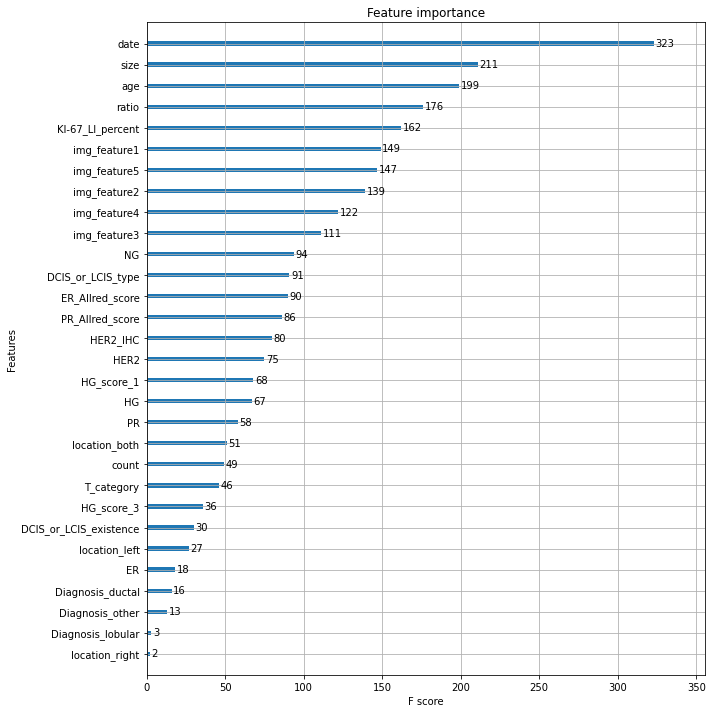

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(simple_model,ax=ax)

In [ ]:
rf_pred = rf.predict(xval)
print(rf.score(xtrain,ytrain))
print(accuracy_score(np.round(rf_pred), yval))
print(classification_report(yval, np.round(rf_pred)))

1.0
0.815
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       100
           1       0.86      0.75      0.80       100

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200



### optuna trial

In [27]:
!pip install --quiet optuna

In [ ]:
import optuna

import sklearn.ensemble
import sklearn.model_selection

from sklearn import svm

Y = train_df['N_category']
X = train_df.drop(columns = ['N_category'])


xtest = test_df.iloc[:,:]

xtrain, xval, ytrain, yval = train_test_split(X,Y,test_size=0.20,random_state=41) 

def objective(trial):
    # iris = sklearn.datasets.load_iris()
    
    C = trial.suggest_int('C', 1, 500)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])
    
    clf = svm.SVC(C=C, kernel = kernel, probability= True)
    
    return sklearn.model_selection.cross_val_score(
        clf, xtrain, ytrain).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2022-12-01 03:13:18,292] A new study created in memory with name: no-name-32e0d3f0-9bb2-4281-92a1-bded266df91f
[I 2022-12-01 03:13:19,874] Trial 0 finished with value: 0.775 and parameters: {'C': 149, 'kernel': 'poly'}. Best is trial 0 with value: 0.775.
[I 2022-12-01 03:13:21,312] Trial 1 finished with value: 0.7799999999999999 and parameters: {'C': 83, 'kernel': 'poly'}. Best is trial 1 with value: 0.7799999999999999.
[I 2022-12-01 03:13:24,099] Trial 2 finished with value: 0.77625 and parameters: {'C': 307, 'kernel': 'poly'}. Best is trial 1 with value: 0.7799999999999999.
[I 2022-12-01 03:13:24,918] Trial 3 finished with value: 0.7775 and parameters: {'C': 240, 'kernel': 'rbf'}. Best is trial 1 with value: 0.7799999999999999.
[I 2022-12-01 03:13:25,717] Trial 4 finished with value: 0.78 and parameters: {'C': 193, 'kernel': 'rbf'}. Best is trial 4 with value: 0.78.
[I 2022-12-01 03:13:26,689] Trial 5 finished with value: 0.77375 and parameters: {'C': 352, 'kernel': 'rbf'}. Best i

### random forest

In [32]:
Y = train_df['N_category']
X = train_df.drop(columns = ['N_category'])


xtest = test_df.iloc[:,:]

from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(X,Y,test_size=0.20,random_state=41) 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators = 381, 
                             criterion = 'log_loss', 
                             max_depth = 96, 
                             min_samples_leaf =  11, 
                             min_samples_split =  0.03078858389657667, 
                             max_leaf_nodes =  42)
clf.fit(xtrain, ytrain)

pred = clf.predict(xval)

print(clf.score(X,Y))
print(accuracy_score(pred, yval))
print(classification_report(yval, pred))

wandb.log({"model score": clf.score(X,Y), "acc": accuracy_score(pred, yval) })

# Mark the run as finished
wandb.finish()

result = clf.predict(xtest)

0.85
0.79
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       100
           1       0.83      0.73      0.78       100

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200



acc,▁
model score,▁
acc,0.79
model score,0.85


In [33]:
# optuna for RF

import optuna

import sklearn.ensemble
import sklearn.model_selection

from sklearn import svm

Y = train_df['N_category']
X = train_df.drop(columns = ['N_category'])


xtest = test_df.iloc[:,:]

xtrain, xval, ytrain, yval = train_test_split(X,Y,test_size=0.10,random_state=41) 

def objective(trial):
    # iris = sklearn.datasets.load_iris()
    
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 2, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    min_samples_split = trial.suggest_float('min_samples_split', 0, 1)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 50)
    
    clf = RandomForestClassifier(n_estimators=n_estimators, criterion = criterion, max_depth= max_depth, 
                  min_samples_leaf=min_samples_leaf,
                  min_samples_split=min_samples_split,
                  max_leaf_nodes=max_leaf_nodes,bootstrap=True)
    
    return sklearn.model_selection.cross_val_score(
        clf, xtrain, ytrain).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2022-12-01 14:05:14,497] A new study created in memory with name: no-name-071e5b53-7dbe-4c8f-a119-689a54eb4bfc
[I 2022-12-01 14:05:15,520] Trial 0 finished with value: 0.7933333333333333 and parameters: {'n_estimators': 351, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 0.21761444680498587, 'max_leaf_nodes': 21}. Best is trial 0 with value: 0.7933333333333333.
[I 2022-12-01 14:05:16,411] Trial 1 finished with value: 0.5155555555555555 and parameters: {'n_estimators': 433, 'criterion': 'log_loss', 'max_depth': 4, 'min_samples_leaf': 14, 'min_samples_split': 0.6983949670815747, 'max_leaf_nodes': 3}. Best is trial 0 with value: 0.7933333333333333.
[I 2022-12-01 14:05:16,539] Trial 2 finished with value: 0.5155555555555555 and parameters: {'n_estimators': 56, 'criterion': 'entropy', 'max_depth': 29, 'min_samples_leaf': 49, 'min_samples_split': 0.9014114008720876, 'max_leaf_nodes': 35}. Best is trial 0 with value: 0.7933333333333333.
[I 2022-12-01 14

[I 2022-12-01 14:05:33,951] Trial 27 finished with value: 0.8022222222222222 and parameters: {'n_estimators': 252, 'criterion': 'log_loss', 'max_depth': 70, 'min_samples_leaf': 31, 'min_samples_split': 0.08443384591950585, 'max_leaf_nodes': 6}. Best is trial 11 with value: 0.8066666666666666.
[I 2022-12-01 14:05:34,764] Trial 28 finished with value: 0.7877777777777778 and parameters: {'n_estimators': 256, 'criterion': 'log_loss', 'max_depth': 93, 'min_samples_leaf': 28, 'min_samples_split': 0.19082116902549015, 'max_leaf_nodes': 5}. Best is trial 11 with value: 0.8066666666666666.
[I 2022-12-01 14:05:35,072] Trial 29 finished with value: 0.7866666666666667 and parameters: {'n_estimators': 99, 'criterion': 'log_loss', 'max_depth': 80, 'min_samples_leaf': 23, 'min_samples_split': 0.25549054621302897, 'max_leaf_nodes': 7}. Best is trial 11 with value: 0.8066666666666666.
[I 2022-12-01 14:05:36,075] Trial 30 finished with value: 0.7966666666666666 and parameters: {'n_estimators': 321, 'cri

[I 2022-12-01 14:05:50,307] Trial 54 finished with value: 0.8044444444444444 and parameters: {'n_estimators': 387, 'criterion': 'entropy', 'max_depth': 40, 'min_samples_leaf': 12, 'min_samples_split': 0.044662510868984824, 'max_leaf_nodes': 33}. Best is trial 51 with value: 0.8077777777777777.
[I 2022-12-01 14:05:51,877] Trial 55 finished with value: 0.8044444444444444 and parameters: {'n_estimators': 396, 'criterion': 'entropy', 'max_depth': 38, 'min_samples_leaf': 6, 'min_samples_split': 0.0545619114868589, 'max_leaf_nodes': 33}. Best is trial 51 with value: 0.8077777777777777.
[I 2022-12-01 14:05:52,730] Trial 56 finished with value: 0.5155555555555555 and parameters: {'n_estimators': 391, 'criterion': 'entropy', 'max_depth': 23, 'min_samples_leaf': 8, 'min_samples_split': 0.807564447090966, 'max_leaf_nodes': 33}. Best is trial 51 with value: 0.8077777777777777.
[I 2022-12-01 14:05:54,415] Trial 57 finished with value: 0.8077777777777777 and parameters: {'n_estimators': 397, 'criter

[I 2022-12-01 14:06:33,799] Trial 81 finished with value: 0.8077777777777777 and parameters: {'n_estimators': 498, 'criterion': 'entropy', 'max_depth': 21, 'min_samples_leaf': 10, 'min_samples_split': 0.030450401453293956, 'max_leaf_nodes': 48}. Best is trial 76 with value: 0.8144444444444444.
[I 2022-12-01 14:06:35,566] Trial 82 finished with value: 0.8033333333333333 and parameters: {'n_estimators': 450, 'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 0.07836767499465584, 'max_leaf_nodes': 43}. Best is trial 76 with value: 0.8144444444444444.
[I 2022-12-01 14:06:36,660] Trial 83 finished with value: 0.7533333333333333 and parameters: {'n_estimators': 429, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 0.5818612754805575, 'max_leaf_nodes': 45}. Best is trial 76 with value: 0.8144444444444444.
[I 2022-12-01 14:06:38,308] Trial 84 finished with value: 0.7988888888888889 and parameters: {'n_estimators': 479, 'crite

[I 2022-12-01 14:07:22,019] Trial 108 finished with value: 0.8011111111111111 and parameters: {'n_estimators': 298, 'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 13, 'min_samples_split': 0.1747821929494679, 'max_leaf_nodes': 47}. Best is trial 76 with value: 0.8144444444444444.
[I 2022-12-01 14:07:24,193] Trial 109 finished with value: 0.8088888888888889 and parameters: {'n_estimators': 486, 'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 6, 'min_samples_split': 0.01487888411685845, 'max_leaf_nodes': 43}. Best is trial 76 with value: 0.8144444444444444.
[I 2022-12-01 14:07:25,675] Trial 110 finished with value: 0.8033333333333333 and parameters: {'n_estimators': 425, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 0.09290345027327136, 'max_leaf_nodes': 44}. Best is trial 76 with value: 0.8144444444444444.
[I 2022-12-01 14:07:27,334] Trial 111 finished with value: 0.8077777777777777 and parameters: {'n_estimators': 437, 'cr

[I 2022-12-01 14:08:14,336] Trial 135 finished with value: 0.8088888888888889 and parameters: {'n_estimators': 446, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.01591694783386684, 'max_leaf_nodes': 41}. Best is trial 115 with value: 0.8155555555555555.
[I 2022-12-01 14:08:15,908] Trial 136 finished with value: 0.8033333333333333 and parameters: {'n_estimators': 390, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 0.0019025475810139185, 'max_leaf_nodes': 40}. Best is trial 115 with value: 0.8155555555555555.
[I 2022-12-01 14:08:17,619] Trial 137 finished with value: 0.8088888888888889 and parameters: {'n_estimators': 408, 'criterion': 'entropy', 'max_depth': 27, 'min_samples_leaf': 5, 'min_samples_split': 0.04035815712358096, 'max_leaf_nodes': 38}. Best is trial 115 with value: 0.8155555555555555.
[I 2022-12-01 14:08:19,418] Trial 138 finished with value: 0.8144444444444444 and parameters: {'n_estimators': 434,

[I 2022-12-01 14:08:58,446] Trial 162 finished with value: 0.8066666666666666 and parameters: {'n_estimators': 379, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 0.01623108756789256, 'max_leaf_nodes': 44}. Best is trial 147 with value: 0.8166666666666667.
[I 2022-12-01 14:08:59,370] Trial 163 finished with value: 0.5155555555555555 and parameters: {'n_estimators': 409, 'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 0.8273870178659513, 'max_leaf_nodes': 46}. Best is trial 147 with value: 0.8166666666666667.
[I 2022-12-01 14:09:01,016] Trial 164 finished with value: 0.8077777777777777 and parameters: {'n_estimators': 425, 'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 7, 'min_samples_split': 0.031243854333071704, 'max_leaf_nodes': 47}. Best is trial 147 with value: 0.8166666666666667.
[I 2022-12-01 14:09:02,437] Trial 165 finished with value: 0.8177777777777777 and parameters: {'n_estimators': 350, 'criteri

[I 2022-12-01 14:09:39,042] Trial 189 finished with value: 0.8066666666666666 and parameters: {'n_estimators': 401, 'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 0.03732355886499861, 'max_leaf_nodes': 49}. Best is trial 181 with value: 0.8188888888888888.
[I 2022-12-01 14:09:40,517] Trial 190 finished with value: 0.8122222222222222 and parameters: {'n_estimators': 363, 'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 7, 'min_samples_split': 0.023790394411681175, 'max_leaf_nodes': 44}. Best is trial 181 with value: 0.8188888888888888.
[I 2022-12-01 14:09:41,401] Trial 191 finished with value: 0.7866666666666667 and parameters: {'n_estimators': 307, 'criterion': 'gini', 'max_depth': 22, 'min_samples_leaf': 5, 'min_samples_split': 0.3434636982216713, 'max_leaf_nodes': 46}. Best is trial 181 with value: 0.8188888888888888.
[I 2022-12-01 14:09:42,786] Trial 192 finished with value: 0.8111111111111111 and parameters: {'n_estimators': 329, 'criteri

[I 2022-12-01 14:10:20,989] Trial 216 finished with value: 0.8133333333333332 and parameters: {'n_estimators': 359, 'criterion': 'gini', 'max_depth': 21, 'min_samples_leaf': 1, 'min_samples_split': 0.00027087712666997745, 'max_leaf_nodes': 49}. Best is trial 181 with value: 0.8188888888888888.
[I 2022-12-01 14:10:22,509] Trial 217 finished with value: 0.8077777777777777 and parameters: {'n_estimators': 353, 'criterion': 'gini', 'max_depth': 23, 'min_samples_leaf': 1, 'min_samples_split': 0.0016342304571459092, 'max_leaf_nodes': 50}. Best is trial 181 with value: 0.8188888888888888.
[I 2022-12-01 14:10:24,021] Trial 218 finished with value: 0.8088888888888889 and parameters: {'n_estimators': 359, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 0.035826425678133676, 'max_leaf_nodes': 49}. Best is trial 181 with value: 0.8188888888888888.
[I 2022-12-01 14:10:24,935] Trial 219 finished with value: 0.7733333333333333 and parameters: {'n_estimators': 334, 'c

[I 2022-12-01 14:11:05,619] Trial 243 finished with value: 0.8044444444444444 and parameters: {'n_estimators': 409, 'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 0.024853087985959324, 'max_leaf_nodes': 45}. Best is trial 181 with value: 0.8188888888888888.
[I 2022-12-01 14:11:07,347] Trial 244 finished with value: 0.8077777777777777 and parameters: {'n_estimators': 440, 'criterion': 'gini', 'max_depth': 17, 'min_samples_leaf': 5, 'min_samples_split': 0.019077682347448208, 'max_leaf_nodes': 43}. Best is trial 181 with value: 0.8188888888888888.
[I 2022-12-01 14:11:09,210] Trial 245 finished with value: 0.8044444444444444 and parameters: {'n_estimators': 476, 'criterion': 'gini', 'max_depth': 23, 'min_samples_leaf': 2, 'min_samples_split': 0.03997986458258617, 'max_leaf_nodes': 48}. Best is trial 181 with value: 0.8188888888888888.
[I 2022-12-01 14:11:10,552] Trial 246 finished with value: 0.7922222222222223 and parameters: {'n_estimators': 431, 'crite

[I 2022-12-01 14:11:48,326] Trial 270 finished with value: 0.8033333333333333 and parameters: {'n_estimators': 224, 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 0.035857654429002364, 'max_leaf_nodes': 49}. Best is trial 181 with value: 0.8188888888888888.
[I 2022-12-01 14:11:50,391] Trial 271 finished with value: 0.8122222222222222 and parameters: {'n_estimators': 451, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 5.12829132541053e-05, 'max_leaf_nodes': 46}. Best is trial 181 with value: 0.8188888888888888.
[I 2022-12-01 14:11:51,584] Trial 272 finished with value: 0.8044444444444444 and parameters: {'n_estimators': 258, 'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 0.0008523044604266776, 'max_leaf_nodes': 44}. Best is trial 181 with value: 0.8188888888888888.
[I 2022-12-01 14:11:53,256] Trial 273 finished with value: 0.8066666666666666 and parameters: {'n_estimators': 402, 'cr

[I 2022-12-01 14:12:36,760] Trial 298 finished with value: 0.8088888888888889 and parameters: {'n_estimators': 483, 'criterion': 'gini', 'max_depth': 22, 'min_samples_leaf': 5, 'min_samples_split': 0.0007979338092198025, 'max_leaf_nodes': 44}. Best is trial 292 with value: 0.82.
[I 2022-12-01 14:12:38,250] Trial 299 finished with value: 0.8066666666666666 and parameters: {'n_estimators': 405, 'criterion': 'gini', 'max_depth': 26, 'min_samples_leaf': 2, 'min_samples_split': 0.065835991426283, 'max_leaf_nodes': 48}. Best is trial 292 with value: 0.82.


Accuracy: 0.82
Best hyperparameters: {'n_estimators': 464, 'criterion': 'entropy', 'max_depth': 26, 'min_samples_leaf': 4, 'min_samples_split': 0.0006869006007911953, 'max_leaf_nodes': 46}
